In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
#import string_movie as sm
#wp=sm.waveProfile
import importlib as imp
from matplotlib import animation

import numpy as np
import pylab as plt
from matplotlib import animation
Writer = animation.writers['ffmpeg']

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

class waveProfile():
    """
    Returns a function of X0/L and t/\tau for a string under tension.
    The initial profile is a piecewise linear displacement from the pinned
    ends at (0,0), (L,0) to a position (X0,1).
    """

    def __init__(self,**kwargs):
        self.opt={}
        self.opt.update(X0=0.5,nmax=50)
        self.opt.update(**kwargs)
        self.N = np.arange(1,self.opt['nmax'])[:,np.newaxis,np.newaxis]



    def c0(self,X0=None):
        #c0: initial Fourier components from string with amplitude y0,
        #displaced at X0=x/L.

        if X0==None:
            X0=self.opt['X0']
        else:
            self.opt['X0']=X0

        n=self.N
        return 2./(n*np.pi)**2/(X0*(1-X0))*np.sin(np.pi*n*X0)


    def fcn(self,x,t):

        #axes: 0 is n, 1 is x, 2 is t
        al = 0.01
        K = self.N
        OM = self.N
        OMc = OM*(1-1j*al*OM)
        #Q-1 = alpha = 2\pi\omega''/\omega' = \omega'\tau
        C = self.c0()

        T = t[np.newaxis,np.newaxis,:]
        X = x[np.newaxis,:,np.newaxis]

        eipi = lambda x: np.exp(1j*np.pi*x)

        rvi=0.5*1j*C*(eipi(K*X-OMc*T)-eipi(-K*X-OMc*T))
        rv = np.sum(rvi,axis=0)

        return rv


class animatedFigure():

    def __init__(self,**kwargs):
        """
        Initializes figure.
        """
        self.opt={}
        self.opt.update(xr=np.linspace(0,1,100),repeats_at=64,nframes=5,
        fn=r'/home/bill/Desktop/string4.mp4',
        writer_kwargs={},
        savefig=False)
        self.opt['writer_kwargs'].update(fps=15, metadata=dict(artist='Me'), bitrate=1800)

        self.opt.update(**kwargs)

        self.y_fcn = waveProfile().fcn
        #self.y_fcn = lambda x,t: np.cos(x-t)

        self.init_fig()

    def init_fig(self):

        """
        Sets up the figure and defines the plot handles,
        stored in self.h dict
        """
        if self.opt['savefig']:
            fig, ax = plt.subplots()
            ax.axis([0,1.0,-1.2,1.2])
            ax.set_xlabel(r"$X=x/L$")
            ax.set_ylabel(r"$y(X,t)$")
            plt.tight_layout()
            l, = ax.plot([],[],label="oh")
            leg = ax.legend()
            plt.close()

            self.h = {}
            self.h.update(fig=fig,ax=ax,l=l,leg=leg)

        else:

            if True:
                fig=plt.figure()
                ax=fig.add_subplot(111)
            else:
                #This syntax is not necessary.
                ax = host_subplot(111, axes_class=AA.Axes)
                fig=ax.get_figure()

            ax.axis([0,1.0,-1.2,1.2])
            ax.set_xlabel(r"$X=x/L$")
            ax.set_ylabel(r"$y(X,t)$")
            plt.tight_layout()
            self.h = {}
            self.h.update(fig=fig,ax=ax)
            #self.h['l'],=ax.plot([],[],'-g',lw=2,label="oh")
            self.h['l'],=ax.plot([],[],'go',lw=2,label="oh")

            self.h['leg'] = ax.legend()






    def init_realtime(self):
        self.h['l'].set_xdata(self.opt['xr'])
        self.h['l'].set_ydata([np.nan] * len(self.opt['xr']))
        return self.h['l'],

    def update_realtime(self,t):
        self.h['l'].set_ydata(np.real(self.y_fcn(self.opt['xr'],np.array([t/self.opt['repeats_at']]))))

        #self.h['leg'].texts[0].set_text(r"$t=$%2i"%t)
        #return self.h['l'],self.h['leg'] updates legend
        #It's a lot faster without the legend.
        return self.h['l'],

    def real_time(self):

        self.ani_obj = animation.FuncAnimation(self.h['fig'],self.update_realtime,init_func=self.init_realtime,interval=2, blit=True, save_count=50)

        #update, init_func=init, frames=len(t), blit=True
        # init_func=init,
        self.h['fig'].canvas.draw()
        plt.show()

    def updater(self,t):

        """
        This updates the plot handles and is the function taken as argument for animation.FuncAnimation
        """

        self.h['l'].set_data(self.opt['xr'],\
        np.real(self.y_fcn(self.opt['xr']),np.array([t/self.opt['repeats_at']])))

        self.h['leg'].texts[0].set_text(r"$t=$%2i"%t)




    def write_file(self):

        self.ani_file = animation.FuncAnimation(self.h['fig'],self.updater, frames=self.opt['nframes']);
        writer = Writer(**self.opt['writer_kwargs'])
        self.ani_file.save(self.opt['fn'], writer=writer)


In [4]:

class clickString():
    
    def __init__(self,**kwargs):
        self.initPlot()
        self.buttonDown=False
        self.opt={}
        self.opt.update(xr=np.linspace(0,1,100),repeats_at=64)
        self.opt.update(**kwargs)
        
    def initPlot(self,fig=None):
        if fig==None:
            self.fig = plt.figure()
        else:
            self.fig=fig
            
        self.wp=waveProfile()
        self.y_fcn = self.wp.fcn
        
        self.ax0 = self.fig.add_subplot(121)
        self.ax1 = self.fig.add_subplot(122)
        self.l, = self.ax0.plot([0,1],[0,0],'r-')
        self.l2 = self.ax1.bar(np.arange(10)+1,self.wp.c0()[:10,0,0]**2.)
        self.ax1.set_yscale('log')
        self.ax1.set_xticks([1,2,3,4,5,6,7,8,9,10])
        self.ax0.set_xlabel(r"$x/L$",size=18)
        self.ax0.set_ylabel(r"$y$",size=18)
        self.ax1.set_ylabel(r"$b_n^2$",size=18)
        self.ax1.set_xlabel(r"Mode number $n$",size=18)
        self.text=self.ax0.text(0,0, "", va="bottom", ha="left")
        plt.tight_layout()
            
        
        self.ax1.set_ylim([1e-7,1])
        #plt.ylim([-0.5,0.5])
        
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        self.rid = self.fig.canvas.mpl_connect('button_release_event', self.onrelease)
        self.mid = self.fig.canvas.mpl_connect('motion_notify_event', self.onmove)
        
    def updateFT(self,event):
        X0=event.xdata
        dat=self.wp.c0(X0=X0)[:10,0,0]**2.
        for r,d in zip(self.l2,dat):
            r.set_height(d)
        
    def onclick(self,event):
        self.l.set_data([0,event.xdata,1],[0,event.ydata,0])
        X0=event.xdata
        #dat=self.wp.c0(X0=X0)[:10,0,0]**2.
        #self.l2.set_data(np.arange(10),dat)
        self.updateFT(event)
        if self.ani_obj:
            self.ani_obj.event_source.stop()
        self.buttonDown = True


    def onrelease(self,event):
        self.buttonDown = False
        self.animate_realtime(event.ydata)

    def onmove(self,event):
        if self.buttonDown:
            self.l.set_data([0,event.xdata,1],[0,event.ydata,0])
            self.updateFT(event)
            
    def init_realtime(self):
        self.l.set_xdata(self.opt['xr'])
        self.l.set_ydata([np.nan] * len(self.opt['xr']))
        return self.l,

    def update_realtime(self,t):
        
        self.l.set_ydata(np.real(self.y0*self.y_fcn(self.opt['xr'],np.array([t/self.opt['repeats_at']]))))

        return self.l,

    def animate_realtime(self,y0):
        self.y0=y0

        self.ani_obj = animation.FuncAnimation(self.fig,self.update_realtime,init_func=self.init_realtime,interval=1, blit=True, save_count=50)
        #self.fig.canvas.draw()
        plt.show()
    

## Sound power in a stringed instrument

### Eigenmodes 

For an elastic string on $0\leq x\leq L$, pinned at the ends, and placed under tension, there are eigenmodes and associated eigenfrequencies, with unit amplitude $A_n$ of

$$ \psi_n(x)=A_n \sin{k_n x}\qquad k_n = n\:\frac{\pi}{L}$$ 

An arbitrary initial string profile can be expanded in these eigenstates:

$$ \psi(x,0) = \sum_{n=1,2,3\ldots} c_n \:\sin{k_n x}$$ 

Which requires

$$ c_n = \int_{-\infty}^{\infty}\: dx\:\psi_n^{*}(x)\:\psi(x) $$

$$ c_n = A_n\int_{0}^{L}\: dx\:\sin{k_n x}\:\psi(x,0) $$

We can calculate these amplitudes and so determine the power in different modes, for various initial string profiles.

[//]: # (

#### Example: left hand step  

Consider that at time=0, the string has the profile

$$ \psi(x)=\frac{1}{\sqrt{D}} \qquad 0\leq x\leq D $$

with a peak amplitude, width $D$, over to the left of the string.  There will be Fourier components at 

$$ c_n = \sqrt{\frac{2}{L}}\frac{1}{\sqrt{D}}\int_{0}^{D}\: dx\:\sin{k_n x} $$

The amplitudes of the profile at $t=0$ are

$$ \boxed{c_n(0) = \sqrt{\frac{2 L}{D}}\frac{1}{n \pi}\left(1-\cos{k_n D}\right)} $$

#### Example: center step  

Alternatively, imagine that the peak is in the center of the box

$$ \psi(x)=\frac{1}{\sqrt{D}} \qquad \frac{L}{2}-\frac{D}{2}\leq x\leq \frac{L}{2}+\frac{D}{2} $$

$$ c_n = \sqrt{\frac{2}{L}}\frac{1}{\sqrt{D}}\left[\frac{\cos{k_n x}}{k_n}\right]^{\left(L+D\right)/2}_{\left(L-D\right)/2}$$

$$ c_n = \sqrt{\frac{2 L}{D}}\frac{1}{n \pi}\left(\cos{\frac{n\pi}{2}\left(1+\frac{D}{L}\right)}-\cos{\frac{n\pi}{2}\left(1-\frac{D}{L}\right)}\right) $$

$$ \boxed{c_n = \sqrt{\frac{2 L}{D}}\frac{2}{n \pi}\left[\sin{\frac{n\pi}{2}}\sin{\left(\frac{n\pi}{2}\frac{D}{L}\right)}\right]} $$

In the limit $D=L$, this would be for the uniform state $c_n^U$

$$ c_n^U = \frac{2\sqrt{2}}{n \pi}\sin^2{\frac{n\pi}{2}} $$

)
#### Example: plucked string 

Next, assume that the string is extended to $y_0$ at a position $x_0$.  $y_0$ can be arbitrary on the string, but on a guitar, it is something like $x_0=L/4$.

$$ \psi(x)= y_0\frac{x}{x_0} \qquad x<x_0$$
$$ \psi(x)= y_0\frac{L-x}{x_0-L} \qquad x\geq x_0 $$

$$ c_n = A_n\left[\frac{y_0}{x_0}\int_{0}^{x_0}\: dx\:x\:\sin{k_n x} + \frac{y_0}{x_0-L} \int_{x_0}^{L}\: dx\:\left(L-x\right)\:\sin{k_n x} \right]$$

After integration by parts, we have


$$ c_n = -\frac{2 y_0 A_n\:L}{x_0\left(L-x_0\right)} \frac{\sin{k_n x_0}}{k_n^2} $$

For simplicity, take $A_n=1$, $X=x/L$:

$$ c_n = -\frac{2 y_0 L}{n^2 \pi^2 X_0\left(1-X_0\right)} \sin{n \pi X_0} $$


## Pluck the string

Using the mouse over the left figure, which simulates the initial position of the tensioned string, hold down the left mouse button to see (on the right) how the spatial Fourier components vary as a function of the tensioning.  (The mouse controls the position $(X_0, y_0)$).  

After tensioning the string, release it by letting go by unclicking, and see how it vibrates.  (n.b. for audible frequencies, this is a slow-motion movie.)



<IPython.core.display.Javascript object>


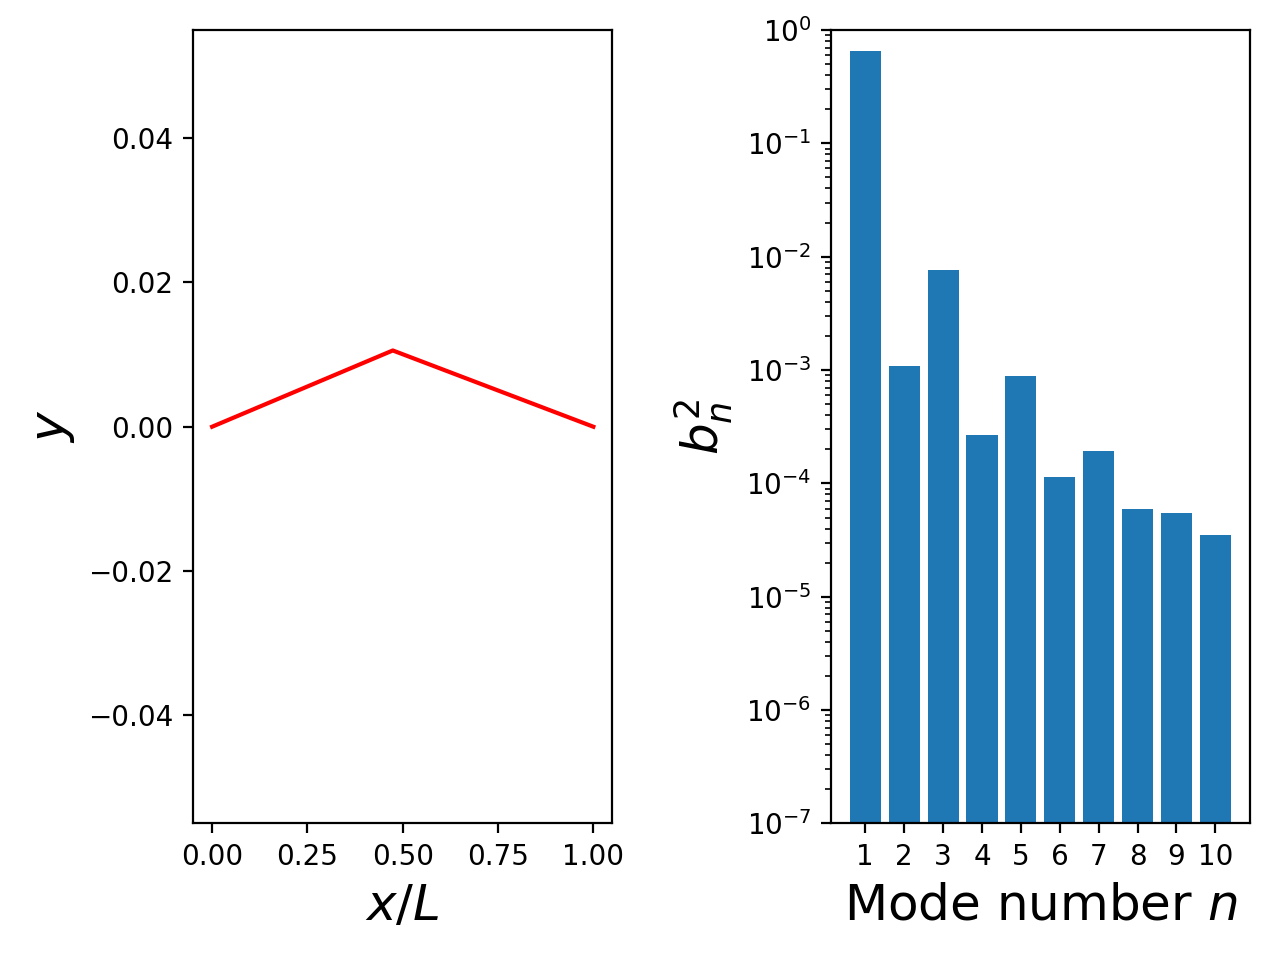

In [5]:
q=clickString();